In [18]:
import xarray as xr
import torch
from torch.nn import functional as F
from torch import nn
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
import os
import argparse
from datetime import date
import json
import copy
from scipy.interpolate import RectBivariateSpline
import scipy
from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import product
#os.system("jupyter nbconvert --to script 'climate_data.ipynb'")
#os.system("jupyter nbconvert --to script 'climate_models.ipynb'")
import climate_train as ct
import climate_data
import climate_models
import climate_job_maintenance as cjm
root='/scratch/cg3306/climate/runs/'

In [19]:
 # FULL TYPE TRAINING
        
# DATASET (2)
# SURF/DEEP 

# ARCHITECTURE (3)
# LCNN/QCNN/UNET

# SIGMAVALS (4)
# 4 8 12 16 

# GEOPHYS (3)
# NONE - GLOBAL - (GLOBAL+COORDS)

# RESIDUE TARGET(2)
# YES - NO



def jobnums(C=[2,3,4,3,2],x=[[0,1],[0,1,2],[0,1,2,3],[1,2],[0]],offset=5000):
    lxi=[len(xx) for xx in x]
    n=np.prod(lxi)
    y=[]
    for i in range(n):
        ii=i
        tt=0
        TT=1
        for j in range(len(x)):
            tt+=x[j][ii%lxi[j]]*TT
            ii=ii//lxi[j]
            TT*=C[j]
        y.append(tt)
    y=[tt+offset for tt in y] 
    return y

In [20]:
args=ct.options(string_input="-b 3".split())

In [21]:
offset=3000
args.model_id=offset
args.model_bank_id="G"
root='/scratch/cg3306/climate/runs/'
C,names=climate_models.golden_model_bank(args,only_description=True,verbose=True)

root improvement 3000
	temp
		no - yes - 
	global
		no - yes - 
	res
		no - yes - 
	geophys
		no - yes - 
	sigma
		4 - 8 - 12 - 16 - 


In [22]:
s=1
x=[[0,1],[1],[0],[0],[s]]
J=cjm.jobnums(C=C,x=x,offset=offset)

#testing res
x=[[1],[1],[0,1],[1],[s]]
J+=cjm.jobnums(C=C,x=x,offset=offset)

missed: /scratch/cg3306/climate/runs/G-3043/binned-edges.npy
missed: /scratch/cg3306/climate/runs/G-3043/binned-equid-edges.npy
missed: /scratch/cg3306/climate/runs/G-3043/binned-mse.npy
missed: /scratch/cg3306/climate/runs/G-3043/binned-sc2.npy
missed: /scratch/cg3306/climate/runs/G-3043/binned-freq.npy
missed: /scratch/cg3306/climate/runs/G-3047/binned-edges.npy
missed: /scratch/cg3306/climate/runs/G-3047/binned-equid-edges.npy
missed: /scratch/cg3306/climate/runs/G-3047/binned-mse.npy
missed: /scratch/cg3306/climate/runs/G-3047/binned-sc2.npy
missed: /scratch/cg3306/climate/runs/G-3047/binned-freq.npy


IndexError: list index out of range

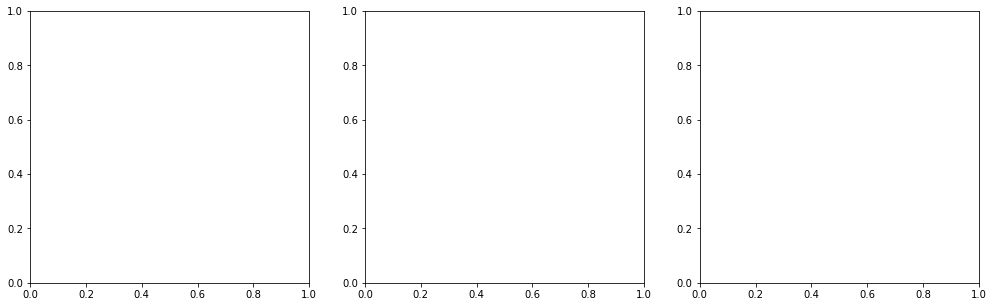

In [35]:
sigmas=[4,8,12,16]
fig,axs=plt.subplots(1,3,figsize=(17,5))
fig.patch.set_facecolor('white')
lines=['glbl','glbl+T','glbl+T+geo','glbl+T+geo+LSR','LSR']
colors=['blue','orange','green','red','purple','olive','pink']
colors=['tab:'+cc for cc in colors]

s=2
# x=[[0,1],[1],[0],[0],[s]]
# J=cjm.jobnums(C=C,x=x,offset=offset)

#testing res
x=[[1],[1],[0,1],[1],[s]]
J=cjm.jobnums(C=C,x=x,offset=offset)

#J=J[1:]
lines=lines[-3:-1]


roots=[root+'G-'+str(J[i]) for i in range(len(J))]

for K in range(1):
    names=['edges','equid-edges','mse','sc2','freq']#'mse-res',
    readvars={}
    for i in range(len(names)):
        readvars[names[i]]=[]
    for i in range(len(roots)):
        for j in range(len(names)):
            try:
                M=np.load(roots[i]+'/binned-'+names[j]+'.npy')
                readvars[names[j]].append(M)
            except:
                print('missed: '+roots[i]+'/binned-'+names[j]+'.npy')
    
    
    depthind=0
    titles=['Momentum']*2+['Temperature']
    titles=['Subgrid '+tt+' Forcing' for tt in titles]
    titles[0]+=' (Longitudinal)'
    titles[1]+=' (Latitudinal)'
    #titles=[tt+'\n sigma= '+str(sigmas[K]) for tt in titles]
    for j in range(3):
        ax=axs[j]
        for i in range(len(roots)):
            freq=readvars['freq'][i]
            edges=readvars['edges'][i]
            medges=(edges[:,:,1:]+edges[:,:,:-1])/2

            #mseres=readvars['mse-res'][0]
            mse=readvars['mse'][i]
            sc2=readvars['sc2'][i]
            r2=mse/sc2
            r2single=np.sum(mse,axis=2)/np.sum(sc2,axis=2)
            w=5
            mr2=r2[:,:,:-(w-1)]*0
            for k in range(mr2.shape[1]):
                mr2[0,k]=np.convolve(r2[0,k], np.ones(w), 'valid') / w
            meqedges=readvars['equid-edges'][i]
            meqedges=(meqedges[:,:,1:]+meqedges[:,:,:-1])/2
            
            ax.loglog(meqedges[depthind,j,:-(w-1)],mr2[depthind,j],color=colors[i],label=lines[i])
            #ax.semilogx(meqedges[depthind,j],r2[depthind,j],'k.')
            #ax.axhline(y=r2single[depthind,j],color=colors[i], linestyle = '--',label=lines[i]+' - avereage R2')
        
        ax.set_ylim([0,50])
        color = 'tab:red'
        if j==0:
            ax.set_ylabel('R2 value', color = color)
        ax.set_xlim([medges[depthind,j][0],medges[depthind,j][-1]])
        ax.set_title(titles[j])
        if j==1:
            ax.set_xlabel('forcing magnitude (1e-7 m/s2)')
        ax2 = ax.twinx()

        
        if j==2:
            ax2.set_ylabel('density', color = color)
        nfreq=freq[depthind,j]/np.sum(freq[depthind,j])
        #cumul=np.cumsum(nfreq)#[::-1])
        #nfreq=cumul#[::-1]
        ax2.loglog(medges[depthind,j],nfreq, color = color,label='density')
        ax2.tick_params(axis ='y', labelcolor = color)
        if j==0:
            ax.legend(loc='upper right')
        elif j==2:
            ax2.legend(loc='upper right')
        ax.grid(color='k',linestyle='--',alpha=0.5)

In [86]:
w=5
mr2=r2[:,:,:-(w-1)]*0
for i in range(3):
    mr2[0,i]=np.convolve(r2[0,i], np.ones(w), 'valid') / w

(0.0, 1.0)

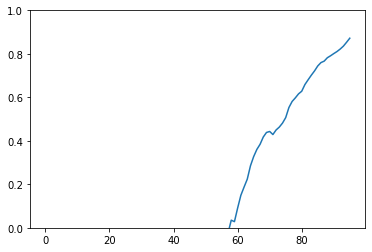

In [87]:
plt.plot(mr2[0,0])
plt.ylim([0,1])

In [36]:
i=0
model_id=jobnums(C=C,x=[[1],[1],[0],[1],[i]],offset=offset)[0]
string_input="-b 4 --lr 0.01 -e 5000 --nworkers 15 \
                --model_bank_id G --disp 1 --depth 0 --model_id "+str(model_id)
args=ct.options(string_input=string_input.split())

In [37]:
net,criterion,(data_init,partition),logs,(PATH0,PATH1,LOG,root)=ct.load_from_save(args)
(training_set,training_generator),(val_set,val_generator),(test_set,test_generator),(dataset,glbl_gen)=ct.load_data(data_init,partition,args)
residue_flag=dataset.outputs[0]=='Su_r'
if residue_flag:
    dataset.outputs+=['Su','Sv','ST']
    dataset.outscales=dataset.outscales*2


device=ct.get_device()
net.eval()
spread=net.spread
noutsig=net.outwidth



if args.depth:
    numdepths=np.maximum(len(training_set.depthvals),1)
else:
    numdepths=1

pooler=nn.MaxPool2d(2*dataset.mask_spread+1,stride=1)

arr=np.arange(len(dataset))
np.random.shuffle(arr)

uv,Sxy=dataset.input_output(arr[0],periodic_lon_expand=True)

def gen_mask(uv,pooler):
    if len(uv.shape)==3:
        MASK=uv[:1]*1
    elif len(uv.shape)==2:
        MASK=uv*1
    MASK[MASK==MASK]=0
    MASK[MASK!=MASK]=1
    MASK=1-pooler(MASK)
    return MASK[0]
MASK=gen_mask(uv,pooler)
sp_extend=np.int64(torch.sum(MASK).item())

LCNN + 21x21 + surface + glbl + lat + coarse(4) + batch= 2
domain id: 3
Loaded the existing model


In [39]:
nbins=1000
nedges=nbins+1
edges=np.linspace(-6,6,nedges)

In [68]:
VALS=torch.zeros(numdepths,noutsig,nbins)
if residue_flag:
    VALSRES=torch.zeros(numdepths,noutsig,nbins)
for di in range(len(dataset)*numdepths):
    i=di%len(dataset)
    depthind=di//len(dataset)
    if args.depth:
        dataset.depthind=depthind
        uv,Sxy=dataset.input_output(arr[i],scale=False,periodic_lon_expand=True)
        if i==0:
            training_set.depthind=depthind
            insc,outsc=training_set.compute_scales()
            insc,outsc=np.reshape(insc,[-1,1,1]),np.reshape(outsc,[-1,1,1])
            if residue_flag:
                outsc=np.concatenate([outsc,outsc],axis=0)
            MASK=gen_mask(uv,pooler)
        uv=uv/insc
        Sxy=Sxy/outsc
        Sxy[Sxy!=Sxy]=0
        uv[uv!=uv]=0
    else:
        outsc=np.array(dataset.outscales).reshape([-1,1,1])
        uv,Sxy=dataset.input_output(arr[i],scale=True,periodic_lon_expand=True)
        Sxy[Sxy!=Sxy]=0
        uv[uv!=uv]=0
    if residue_flag:
        Sxy1,Sxy=torch.split(Sxy,[3,3],dim=0)
    uv=torch.stack([uv]).to(device)
    with torch.set_grad_enabled(False):
        if isinstance(net, climate_models.RegressionModel):
            output=net.forward(uv,w)
        else:
            output=net.forward(uv)
    output=output[0].to(torch.device("cpu"))
    output,prec,_=torch.split(output,[noutsig,net.nprecision,output.shape[0]-noutsig-net.nprecision],dim=0)
    output=output[:,MASK==1]
    Sxy=Sxy[:,MASK==1]
    prec=prec[:,MASK==1]
    if residue_flag:
        Sxy1=Sxy1[:,MASK==1]
        qvals=(Sxy1-output)*torch.sqrt(prec)
        qvalsres=Sxy1
    else:
        qvals=(Sxy-output)*torch.sqrt(prec)
        
    for j in range(len(qvals)):
        for bi in range(nbins):
            qq=qvals[j]
            VALS[depthind,j,bi]+=torch.sum((qq>edges[bi])*(qq<edges[bi+1])).item()
    if residue_flag:       
        for j in range(len(qvals)):
            for bi in range(nbins):
                qq=qvalsres[j]
                VALSRES[depthind,j,bi]+=torch.sum((qq>edges[bi])*(qq<edges[bi+1])).item()
    

In [ ]:

VALS[depthind,:,i*sp_extend:(i+1)*sp_extend]=qvals
if residue_flag:
    VALSRES[depthind,:,i*sp_extend:(i+1)*sp_extend]=qvalsres

In [5]:
def give_vals(args):
    net,criterion,(data_init,partition),logs,(PATH0,PATH1,LOG,root)=ct.load_from_save(args)
    (training_set,training_generator),(val_set,val_generator),(test_set,test_generator),(dataset,glbl_gen)=ct.load_data(data_init,partition,args)
    residue_flag=dataset.outputs[0]=='Su_r'
    if residue_flag:
        dataset.outputs+=['Su','Sv','ST']
        dataset.outscales=dataset.outscales*2


    device=ct.get_device()
    net.eval()
    spread=net.spread
    noutsig=net.outwidth



    if args.depth:
        numdepths=np.maximum(len(training_set.depthvals),1)
    else:
        numdepths=1

    pooler=nn.MaxPool2d(2*dataset.mask_spread+1,stride=1)

    arr=np.arange(len(dataset))
    np.random.shuffle(arr)

    uv,Sxy=dataset.input_output(arr[0],periodic_lon_expand=True)

    def gen_mask(uv,pooler):
        if len(uv.shape)==3:
            MASK=uv[:1]*1
        elif len(uv.shape)==2:
            MASK=uv*1
        MASK[MASK==MASK]=0
        MASK[MASK!=MASK]=1
        MASK=1-pooler(MASK)
        return MASK[0]
    MASK=gen_mask(uv,pooler)
    sp_extend=np.int64(torch.sum(MASK).item())
    nt=15


    VALS=torch.zeros(numdepths,noutsig,sp_extend*nt)
    if residue_flag:
        VALSRES=torch.zeros(numdepths,noutsig,sp_extend*nt)
    for di in range(nt*numdepths):
        i=di%len(dataset)
        depthind=di//len(dataset)
        if args.depth:
            dataset.depthind=depthind
            uv,Sxy=dataset.input_output(arr[i],scale=False,periodic_lon_expand=True)
            if i==0:
                training_set.depthind=depthind
                insc,outsc=training_set.compute_scales()
                insc,outsc=np.reshape(insc,[-1,1,1]),np.reshape(outsc,[-1,1,1])
                if residue_flag:
                    outsc=np.concatenate([outsc,outsc],axis=0)
                MASK=gen_mask(uv,pooler)
            uv=uv/insc
            Sxy=Sxy/outsc
            Sxy[Sxy!=Sxy]=0
            uv[uv!=uv]=0
        else:
            outsc=np.array(dataset.outscales).reshape([-1,1,1])
            uv,Sxy=dataset.input_output(arr[i],scale=True,periodic_lon_expand=True)
            Sxy[Sxy!=Sxy]=0
            uv[uv!=uv]=0
        if residue_flag:
            Sxy1,Sxy=torch.split(Sxy,[3,3],dim=0)
        uv=torch.stack([uv]).to(device)
        with torch.set_grad_enabled(False):
            if isinstance(net, climate_models.RegressionModel):
                output=net.forward(uv,w)
            else:
                output=net.forward(uv)
        output=output[0].to(torch.device("cpu"))
        output,prec,_=torch.split(output,[noutsig,net.nprecision,output.shape[0]-noutsig-net.nprecision],dim=0)
        output=output[:,MASK==1]
        Sxy=Sxy[:,MASK==1]
        prec=prec[:,MASK==1]
        if residue_flag:
            Sxy1=Sxy1[:,MASK==1]
            qvals=(Sxy1-output)*torch.sqrt(prec)
            qvalsres=Sxy1
        else:
            qvals=(Sxy-output)*torch.sqrt(prec)
        VALS[depthind,:,i*sp_extend:(i+1)*sp_extend]=qvals
        if residue_flag:
            VALSRES[depthind,:,i*sp_extend:(i+1)*sp_extend]=qvalsres
    
    if residue_flag:
        return VALS,VALSRES
    else:
        return VALS, []

In [6]:
offset=3000
args.model_id=offset
args.model_bank_id="G"
root='/scratch/cg3306/climate/runs/'
C,names=climate_models.golden_model_bank(args,only_description=True,verbose=True)

root improvement 3000
	temp
		no - yes - 
	global
		no - yes - 
	res
		no - yes - 
	geophys
		no - yes - 
	sigma
		4 - 8 - 12 - 16 - 


LCNN + 21x21 + surface + glbl + lat + coarse(4) + batch= 2


/ext3/miniconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


domain id: 3
Loaded the existing model
LCNN + 21x21 + surface + res + glbl + lat + coarse(4) + batch= 2
domain id: 3
Loaded the existing model
LCNN + 11x11 + surface + glbl + lat + coarse(8) + batch= 8
domain id: 3
Loaded the existing model
LCNN + 11x11 + surface + res + glbl + lat + coarse(8) + batch= 8
domain id: 3
Loaded the existing model
LCNN + 7x7 + surface + glbl + lat + coarse(12) + batch= 18
domain id: 3
Loaded the existing model
LCNN + 7x7 + surface + res + glbl + lat + coarse(12) + batch= 18
domain id: 3
Loaded the existing model
LCNN + 5x5 + surface + glbl + lat + coarse(16) + batch= 32
domain id: 3
Loaded the existing model
LCNN + 5x5 + surface + res + glbl + lat + coarse(16) + batch= 32
domain id: 3
Loaded the existing model


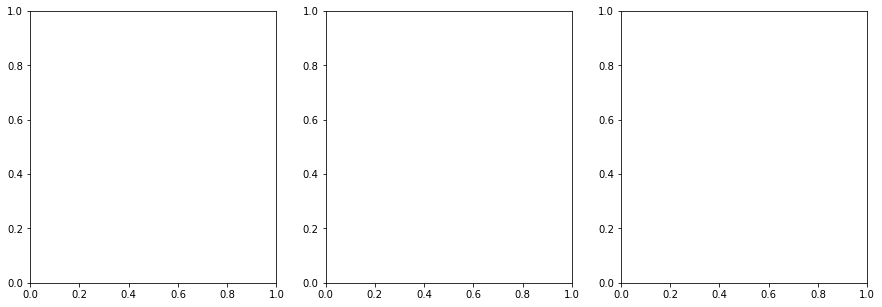

In [7]:
sigmas=[4,8,12,16]

datype=['Surface Subgrid Momentum Forcing \n (Long.)','Surface Subgrid Momentum Forcing \n (Lat.)','Surface Subgrid Temperature Forcing']




    
    

ARGS=[]
VALS=[]
for i in range(len(sigmas)):
    model_id=jobnums(C=C,x=[[1],[1],[0],[1],[i]],offset=offset)[0]
    string_input="-b 4 --lr 0.01 -e 5000 --nworkers 15 \
                    --model_bank_id G --disp 1 --depth 0 --model_id "+str(model_id)
    args=ct.options(string_input=string_input.split())
    VALS_,_=give_vals(args)
    VALS.append(VALS_)
    
    model_id=jobnums(C=C,x=[[1],[1],[1],[1],[i]],offset=offset)[0]
    string_input="-b 4 --lr 0.01 -e 5000 --nworkers 15 \
                    --model_bank_id G --disp 1 --depth 0 --model_id "+str(model_id)
    args=ct.options(string_input=string_input.split())
    VALS_,VALRES_=give_vals(args)
    VALS.append(VALS_)
    VALS.append(VALRES_)

In [15]:
len(VALS_)

12

0
1
2
3


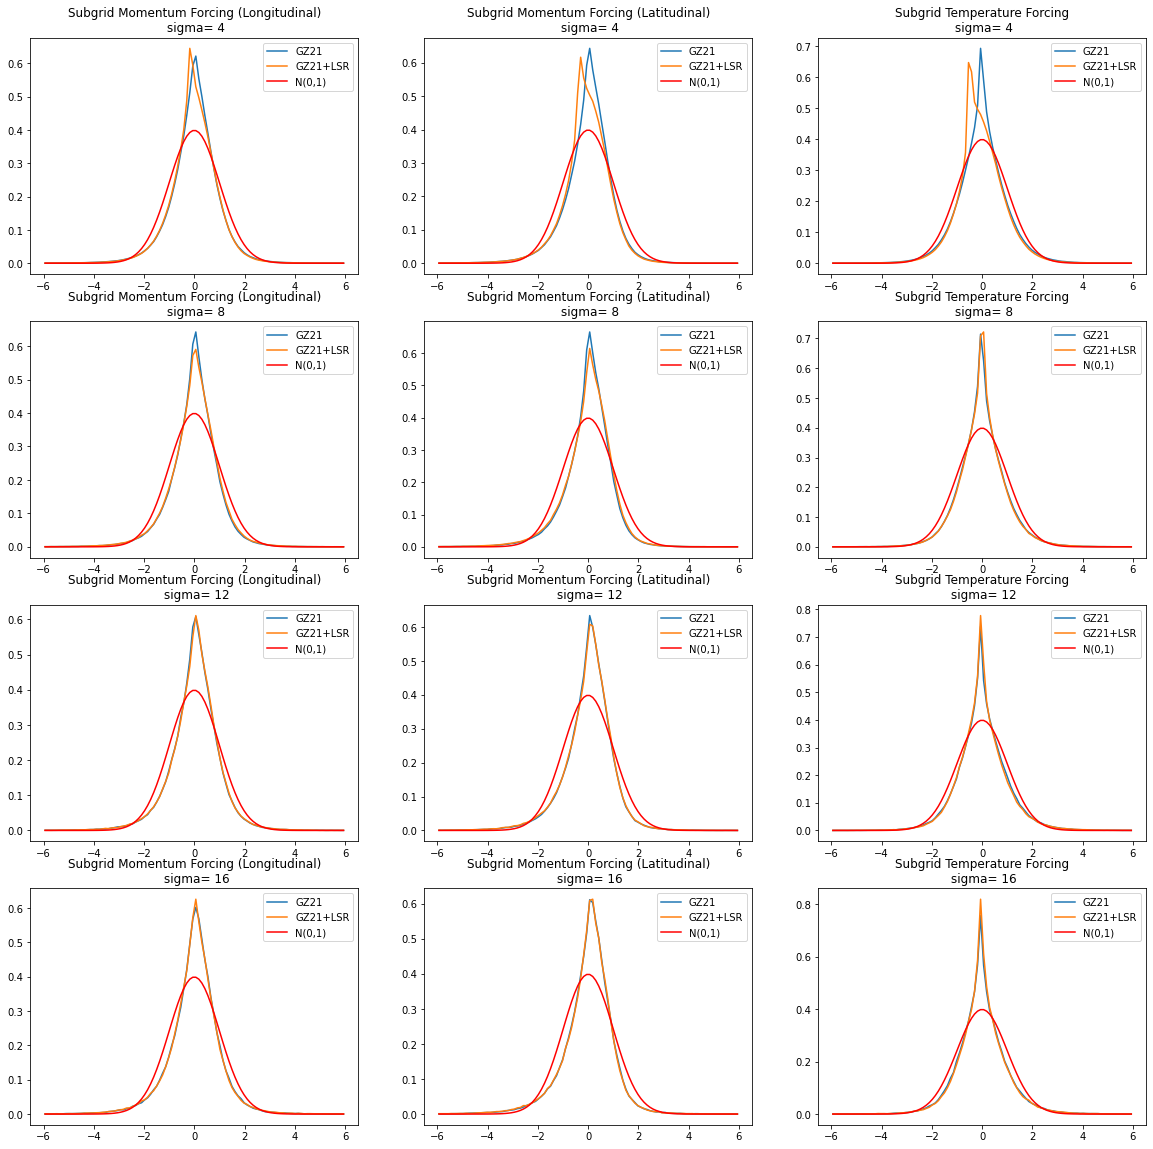

In [17]:
fig,axs=plt.subplots(4,3,figsize=(20,20))
fig.patch.set_facecolor('white')
labels=['GZ21','GZ21+LSR']
sigmas=[4,8,12,16]


for s in range(4):
    titles=['Momentum']*2+['Temperature']
    titles=['Subgrid '+tt+' Forcing' for tt in titles]
    titles[0]+=' (Longitudinal)'
    titles[1]+=' (Latitudinal)'
    titles=[tt+'\n sigma= '+str(sigmas[s]) for tt in titles]
    print(s)
    VALS=torch.cat([VALS_[s*3],VALS_[s*3+1]],dim=0)
    nedges=100
    edges=torch.linspace(-6,6,nedges+1)
    medges=(edges[1:]+edges[:-1])/2
    FREQ=torch.zeros(VALS.shape[0],VALS.shape[1],nedges)
    for i in range(nedges):
        e1=edges[i]
        e2=edges[i+1]
        for j in range(3):
            FREQ[:,:,i]=torch.sum((VALS>e1)*(VALS<e2),dim=2)

    NGAUSS=torch.exp(-medges**2/2)/np.sqrt(2*np.pi)

    NFREQ=FREQ/(torch.sum(FREQ,dim=2,keepdim=True)*(edges[1]-edges[0]))
    #cnst=1/NFREQ[:,:,500:501]*NGAUSS[500]
    #NFREQ=NFREQ*cnst#torch.sum(NGAUSS)
    for i in range(3):
        ax=axs[s,i]
        for j in range(2):
            ax.plot(medges,NFREQ[j,i],label=labels[j])
        ax.plot(medges,NGAUSS,'r',label='N(0,1)')
        ax.legend()
        ax.set_title(titles[i])

0
1
2
3


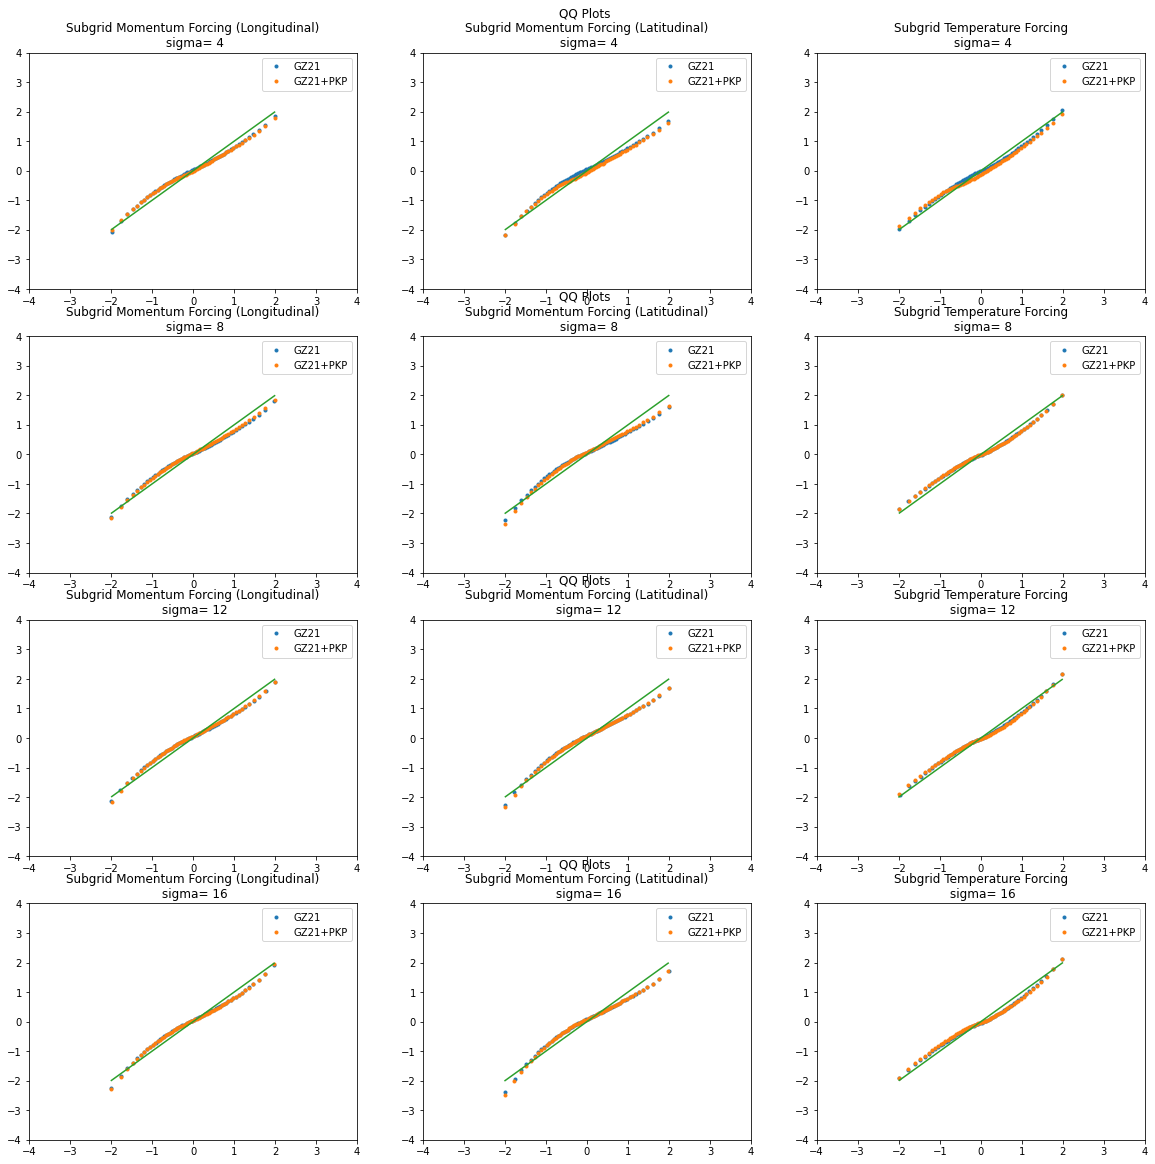

In [11]:
fig,axs=plt.subplots(4,3,figsize=(20,20))
fig.patch.set_facecolor('white')
labels=['GZ21','GZ21+PKP']

for s in range(4):
    VALS=torch.cat([VALS_[s*3],VALS_[s*3+1]],dim=0)
    
    normald=torch.randn(VALS.shape)
    SVALS,_=torch.sort(VALS,dim=2)
    normald,_=torch.sort(normald,dim=2)

    dd=64
    sep=SVALS.shape[2]//dd
    sep2=sep//2

    I=np.arange(1,dd-1)*sep+sep2
    
    titles=['Momentum']*2+['Temperature']
    titles=['Subgrid '+tt+' Forcing' for tt in titles]
    titles[0]+=' (Longitudinal)'
    titles[1]+=' (Latitudinal)'

    titles[1]='QQ Plots \n'+ titles[1]
    titles=[tt+'\n sigma= '+str(sigmas[s]) for tt in titles]
    
    print(s)
    for i in range(3):
        ax=axs[s,i]
        for j in range(2):
            SI=SVALS[j,i,I]
            NI=normald[j,i,I]

            '''SI0=SI[torch.abs(SI)<0.5]
            NI0=NI[torch.abs(SI)<0.5]

            X=torch.stack([SI0,SI0*0+1],dim=1)

            A=X.T@X
            B=X.T@NI0

            w=np.linalg.solve(A.numpy(),B.numpy())

            SI=SI*w[0]+w[1]'''


            NI=normald[j,i,I]
            ax.plot(NI,SI,'.',label=labels[j])
        ax.plot(NI,NI)
        ax.legend()
        ax.set_title(titles[i])
        ax.set_xlim([-4,4])
        ax.set_ylim([-4,4])